In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import unix_timestamp, lit
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import corr
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [4]:
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()
df = spark.read.csv('uber-raw-data-aug14(1).csv', header=True, inferSchema=True)
df.show()

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

In [5]:
df.show()
df.printSchema()


+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

In [4]:
df.describe().show()

+-------+----------------+--------------------+-------------------+------+
|summary|       Date/Time|                 Lat|                Lon|  Base|
+-------+----------------+--------------------+-------------------+------+
|  count|          829275|              829275|             829275|829275|
|   mean|            null|  40.737780735823705|  -73.9701603131643|  null|
| stddev|            null|0.043628060846870514|0.06148272834516594|  null|
|    min|8/1/2014 0:00:00|             39.6569|           -74.7737|B02512|
|    max|8/9/2014 9:59:00|             41.3182|           -72.3359|B02764|
+-------+----------------+--------------------+-------------------+------+



In [6]:
string_cols = [c for c, t in df.dtypes if t == "string"]
indexers = {c: StringIndexer(inputCol=c, outputCol=c+"_index") for c in string_cols}

indexed_df = df
for c, indexer in indexers.items():
    indexed_df = indexer.fit(indexed_df).transform(indexed_df)
print("Before:")
indexed_df.show(3)
numeric_cols = [c for c, t in indexed_df.dtypes if t in ["int", "double", "float", "long"]]
numeric_df = indexed_df.select(numeric_cols)
print("**********************************************************************************\nAfter:")
numeric_df.show(3)

Before:
+----------------+-------+--------+------+---------------+----------+
|       Date/Time|    Lat|     Lon|  Base|Date/Time_index|Base_index|
+----------------+-------+--------+------+---------------+----------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|        20173.0|       4.0|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|        34403.0|       4.0|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|        25098.0|       4.0|
+----------------+-------+--------+------+---------------+----------+
only showing top 3 rows

**********************************************************************************
After:
+-------+--------+---------------+----------+
|    Lat|     Lon|Date/Time_index|Base_index|
+-------+--------+---------------+----------+
|40.7366|-73.9906|        20173.0|       4.0|
| 40.726|-73.9918|        34403.0|       4.0|
|40.7209|-74.0507|        25098.0|       4.0|
+-------+--------+---------------+----------+
only showing top 3 rows



In [8]:
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print("Nulls:")
null_counts.show()
print("We have no null values in this dataset.")

Nulls:
+---------+---+---+----+
|Date/Time|Lat|Lon|Base|
+---------+---+---+----+
|        0|  0|  0|   0|
+---------+---+---+----+

We have no null values in this dataset.


In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import unix_timestamp, lit
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import corr
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [10]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
import pickle

# Create a list to store the cost values for different values of k
cost = []

# Combine the 'Lat' and 'Lon' columns into a single feature vector column
assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol='features')
data = assembler.transform(df.select('Lat', 'Lon'))

# Split the data into training and testing sets with a 80:20 ratio
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=0)


In [11]:
# Perform K-means clustering for k values ranging from 2 to 10
for i in range(2, 11):
    kmeans = KMeans(k=i, seed=0)
    model = kmeans.fit(data.select('Lat', 'Lon' , 'features'))
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print(f"ComputeCost in {i} = " + str(silhouette))
    cost.append(silhouette)

ComputeCost in 2 = 0.8441729203741919
ComputeCost in 3 = 0.8555013245006515
ComputeCost in 4 = 0.8386139014565683
ComputeCost in 5 = 0.841758039833764
ComputeCost in 6 = 0.6517591564842368
ComputeCost in 7 = 0.6128642346393876
ComputeCost in 8 = 0.5548516127648466
ComputeCost in 9 = 0.5832692498212003
ComputeCost in 10 = 0.5421939605050954


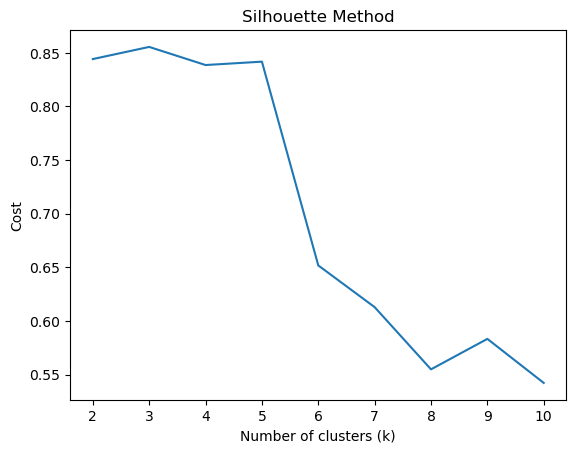

In [13]:
# Plot the cost values for different values of k
plt.plot(range(2, 11), cost)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Silhouette Method')
plt.show()

In [14]:

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
import pickle


# Combine the 'Lat' and 'Lon' columns into a single feature vector column
assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol='features')
data = assembler.transform(df.select('Lat', 'Lon'))


# Split the data into training and testing sets with a 80:20 ratio
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=0)

# Train  K-means clustering model on the training set
kmeans = KMeans(k=3, seed=0)
model = kmeans.fit(trainingData)

# Predict the cluster labels for the testing set
predictions = model.transform(testData)


In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Save the trained model to a file
model.write().overwrite().save("c:/kmeans_model")

# Convert the PySpark KMeans model object into a Python object
pickle_model = {'clusterCenters': model.clusterCenters(), 'k': model.getK()}
mymodel = KMeansModel.load("c:/kmeans_model")

# Write the Python KMeans model object to a pickle file
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(pickle_model, f)

Py4JJavaError: An error occurred while calling o1113.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:736)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:271)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:287)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.hadoop.mapred.FileOutputCommitter.setupJob(FileOutputCommitter.java:131)
	at org.apache.hadoop.mapred.OutputCommitter.setupJob(OutputCommitter.java:265)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:178)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:79)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1061)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1008)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1007)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:964)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:962)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1578)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1578)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1564)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1564)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.clustering.InternalKMeansModelWriter.write(KMeans.scala:198)
	at org.apache.spark.ml.util.GeneralMLWriter.saveImpl(ReadWrite.scala:260)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:548)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:569)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:592)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:689)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1886)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1846)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1819)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:335)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:344)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:898)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1043)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1052)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:468)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:439)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:516)
	... 22 more


In [26]:
from kafka import KafkaProducer
from time import sleep
import json
from datetime import datetime


In [27]:
producer = KafkaProducer(bootstrap_servers=['localhost:9092'])


In [28]:
producer.send('your_topic', b'your_message')


In [31]:
from kafka import KafkaConsumer


In [32]:
consumer = KafkaConsumer('your_topic', bootstrap_servers=['localhost:9092'], auto_offset_reset='latest', enable_auto_commit=True)


In [33]:
#producer code
producer = KafkaProducer(bootstrap_servers=['localhost:9092'])
train_data, test_data = df.randomSplit([0.8, 0.2], seed=40)
print(f"Kafka : Sending Test_data rows using Kafka Producer. total rows: {test_data.count()}.")
for row in test_data.toJSON().collect():
    producer.send("newfile", row.encode('utf-8'))
producer.close()
print("Kafka : Sending Test_data Complete.")

Kafka : Sending Test_data rows using Kafka Producer. total rows: 165908.
Kafka : Sending Test_data Complete.


In [ ]:
#consumer code
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from kafka import KafkaConsumer
import json
import time

# create a SparkSession
spark = SparkSession.builder.appName("KafkaConsumer").getOrCreate()

# Kafka Consumer parameters
bootstrap_servers = ['localhost:9092']
auto_offset_reset = 'earliest'
enable_auto_commit = True
group_id = 'my-group'
topic_name = 'newfile'

# list to specify order of columns in input data
input_col_order = ['Lat', 'Lon', 'Date/Time-seconds', 'Base-Numerical']

# define the schema for the incoming data
schema = StructType([
    StructField("Lat", DoubleType(), True),
    StructField("Lon", DoubleType(), True),
    StructField("Date/Time-seconds", IntegerType(), True),
    StructField("Base-Numerical", StringType(), True)
])

# create a global DataFrame to hold the results
Final_df = spark.createDataFrame([], schema)

# create a function to process incoming messages from Kafka
def create_dataframe_and_predict(messages):
    global Final_df
    message_list = [msg for _, msg in messages.items()]
    if not message_list:
        return
    for message in message_list:
        message_dict = json.loads(message.value.decode('utf-8'))
        df = spark.createDataFrame([message_dict])
        df = df.select(input_col_order)
        assembler = VectorAssembler(inputCols=input_col_order[:3], outputCol="features")
        pipeline = Pipeline(stages=[assembler])
        df = pipeline.fit(df).transform(df)
        model = RandomForestRegressor.load('my_model')
        predictions = model.transform(df)
        predictions = predictions.select('prediction')
        Final_df = Final_df.union(predictions)


# create a Kafka Consumer object
consumer = KafkaConsumer(
    topic_name, 
    bootstrap_servers=bootstrap_servers,
    auto_offset_reset=auto_offset_reset,
    enable_auto_commit=enable_auto_commit,
    group_id=group_id,
    value_deserializer=lambda x: x.decode('utf-8'))

# main loop
while True:
    messages = consumer.poll(timeout_ms=10000)
    create_dataframe_and_predict(messages.values())
    if Final_df.count() > 0:
        Final_df.write.mode('append').csv('uber-raw-data-aug14(1).csv', header=True)
